Epoch 0, Total Loss: 0.624802
Epoch 500, Total Loss: 0.013874
Epoch 1000, Total Loss: 0.041154
Epoch 1500, Total Loss: 0.008616
Epoch 2000, Total Loss: 0.009739
Epoch 2500, Total Loss: 0.017292
Epoch 3000, Total Loss: 0.013827
Epoch 3500, Total Loss: 0.008680
Epoch 4000, Total Loss: 0.007739
Epoch 4500, Total Loss: 0.008850


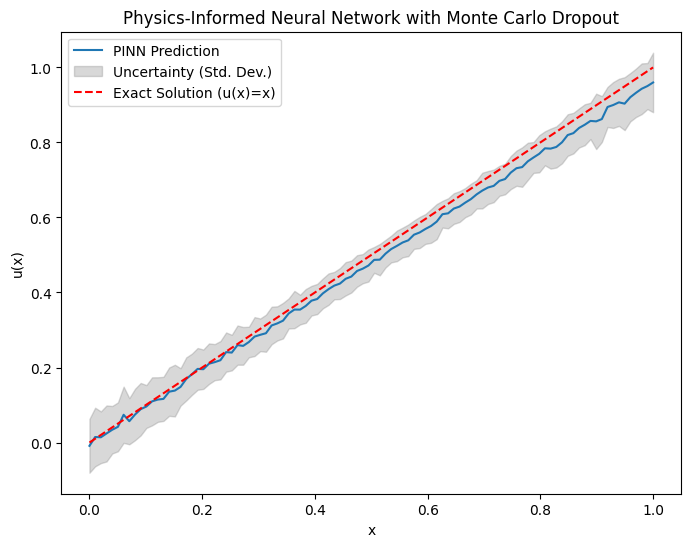

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define a simple PINN model with dropout layers to enable Monte Carlo dropout later.
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # A simple feed-forward network with two hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, 20),   # Input layer to first hidden layer
            nn.Tanh(),          # Activation function
            nn.Dropout(0.1),    # Dropout with 10% probability
            nn.Linear(20, 20),  # First hidden to second hidden layer
            nn.Tanh(),          # Activation function
            nn.Dropout(0.1),    # Another dropout layer
            nn.Linear(20, 1)    # Output layer (approximation of u(x))
        )
        
    def forward(self, x):
        return self.net(x)

# Define the physics residual function.
# For our differential equation u''(x)=0, we compute the second derivative using autograd.
def compute_physics_residual(model, x):
    # Enable gradient computation on input
    x.requires_grad = True
    u = model(x)
    
    # Compute first derivative du/dx
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Compute second derivative d²u/dx²
    grad_u2 = torch.autograd.grad(grad_u, x, grad_outputs=torch.ones_like(grad_u), create_graph=True)[0]
    
    return grad_u2

# Function to perform Monte Carlo dropout predictions.
# We run multiple forward passes with dropout activated (by setting model to train mode)
# and then compute the mean and standard deviation of the predictions.
def predict_with_uncertainty(model, x, n_samples=100):
    model.train()  # Activate dropout even during inference
    predictions = []
    for _ in range(n_samples):
        pred = model(x)
        predictions.append(pred.detach().cpu().numpy())
    predictions = np.array(predictions)
    pred_mean = predictions.mean(axis=0)
    pred_std = predictions.std(axis=0)
    return pred_mean, pred_std

# Hyperparameters and training settings
epochs = 5000          # Total training epochs
lr = 0.001             # Learning rate
n_collocation = 100    # Number of collocation points in the domain [0, 1]

# Create an instance of the PINN model
model = PINN()

# Use Adam optimizer and mean squared error (MSE) loss
optimizer = optim.Adam(model.parameters(), lr=lr)
mse_loss = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Generate collocation points (for physics loss)
    x_coll = torch.linspace(0, 1, n_collocation).view(-1, 1)
    # Compute the physics residual (should be zero for u''(x)=0)
    residual = compute_physics_residual(model, x_coll)
    loss_physics = mse_loss(residual, torch.zeros_like(residual))
    
    # Compute boundary loss at x=0 and x=1:
    x_boundary = torch.tensor([[0.0], [1.0]])
    u_boundary_pred = model(x_boundary)
    u_boundary_true = torch.tensor([[0.0], [1.0]])
    loss_boundary = mse_loss(u_boundary_pred, u_boundary_true)
    
    # Total loss is the sum of physics loss and boundary loss
    loss = loss_physics + loss_boundary
    
    # Backpropagation and optimization step
    loss.backward()
    optimizer.step()
    
    # Print training progress every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}")

# After training, evaluate the model using Monte Carlo dropout to get uncertainty estimates.
# We generate a dense grid of points in [0,1] for prediction.
x_test = torch.linspace(0, 1, 100).view(-1, 1)
mean_prediction, uncertainty = predict_with_uncertainty(model, x_test, n_samples=100)

# Plot the PINN prediction with uncertainty bands.
plt.figure(figsize=(8, 6))
# Plot the mean prediction of the PINN
plt.plot(x_test.detach().cpu().numpy(), mean_prediction, label='PINN Prediction')
# Fill the area between (mean - std) and (mean + std) to show uncertainty
plt.fill_between(x_test.detach().cpu().numpy().flatten(), 
                 (mean_prediction - uncertainty).flatten(), 
                 (mean_prediction + uncertainty).flatten(), 
                 color='gray', alpha=0.3, label='Uncertainty (Std. Dev.)')
# Plot the exact solution u(x) = x
plt.plot(x_test.detach().cpu().numpy(), x_test.detach().cpu().numpy(), 'r--', label='Exact Solution (u(x)=x)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Physics-Informed Neural Network with Monte Carlo Dropout')
plt.legend()
plt.show()
